# Notebook 1: Data Cleaning and NLP pre-processing

## Overview

This notebook takes in raw data of the below structure:

| Document | Sentence                        | Trigger             | Multiclass |
|----------|---------------------------------|---------------------|------------|
| Doc_1    | The Borrower has established... | Loan Default        | 1          |
| Doc_1    | The Borrower has established... | Aggregate DSCR Fall | 1          |
| Doc_1    | "Trigger Period" means any...   | DSCR Fall           | 0          |

And returns a reshaped dataframe in which each Document's sentences are represented only once, with a matrix representation of the trigger types that are maintained. NLP processing is also performed, via Spacy's tokenization and lemmatization functions.

Steps performed by the included functions:
- import raw data
- clean data
- visualize raw data (presenting number of times each trigger appears in the raw data set)
- tokenize and lemmatize data using Spacy
- export processed data

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import spacy
import en_core_web_lg
from spacy.lang.en import English
nlp = spacy.load('en_core_web_lg', disable = 'parser')

## Define cleaning functions

In [2]:
# Function to get data from the original CSV file
def get_data():
    # Import the CSV file
    raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_16_20.csv')
    raw_df = raw_df.dropna(how='all')
    return raw_df

In [3]:
# Create visualization of the triggers contained in the raw data
def explore_data_cleaning(raw_df):
    trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
    ax.set_title('Number of Trigger Labels in Raw Data', fontsize = 18)

    plt.xlabel('Count', fontsize = 18)
    plt.ylabel('Trigger', fontsize = 18)
    plt.tick_params(labelsize=15)
    
    for p in ax.patches:
        ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=12,textcoords='offset points', horizontalalignment='right')
    
    #https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots
    return

In [4]:
# Function to clean data
def clean_data(raw_df, print_fns=False):
    # project out extra columns
    raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]
    
    # Convert each category to Title format (to remove discrepancies based on capitalization)
    raw_df['Trigger'] = raw_df['Trigger'].str.title()

    # Some data fixes
    raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')
    raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

    # Some dollar sign symbols are causing problems - will remove them here
    raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

    # Drop Multiclass column since it isn't needed
    raw_df = raw_df.drop('Multiclass', axis = 1)
    
    # Count the number of distinct documents
    num_docs = raw_df['Document'].nunique()
    print(f'{num_docs} unique documents have been included in the data set')
    
    # Summarize the trigger counts for the existing Document set
    max_triggers = raw_df['Document'].value_counts().max()
    min_triggers = raw_df['Document'].value_counts().min()
    print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

    # run the extra code that analyzes the data
    if print_fns:
        explore_data_cleaning(raw_df)
        
    return raw_df

In [5]:
# Function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates. Export to CSV.
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']

    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)

    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')

        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
        
    # replace nulls with False
    reshaped = reshaped.fillna(0)

    # Export reshaped to CSV file
    reshaped.to_csv('../data/exported_data/reshaped.csv')
    
    return reshaped

In [6]:
# Function to tokenize the sentences into individual words
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

In [7]:
# Function to lemmatize the words, bringing them to their root form
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [8]:
# NLP processing the sentence columns to prep for models
def lemmatize_sentences(dataframe):
    print('Tokenizing the input sentences...')
    dataframe['SentenceTokens'] = dataframe['Sentence'].apply(tokenize).str.replace("[^a-zA-Z']", " ").str.replace('\s{2,}', ' ')
    dataframe['SentenceLemmas'] = dataframe['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z']", " ").str.replace('\s{2,}', ' ')
    print(f"{len(dataframe['Sentence'])} sentences have been tokenized and lemmatized.")
    print("\n")
    dataframe.to_csv('../data/exported_data/reshaped_lemmatized.csv')
    return dataframe

## Perform all cleaning steps + export reshaped data

36 unique documents have been included in the data set
The 36 Documents have tag counts that range from 25 to 176.
Tokenizing the input sentences...
2280 sentences have been tokenized and lemmatized.




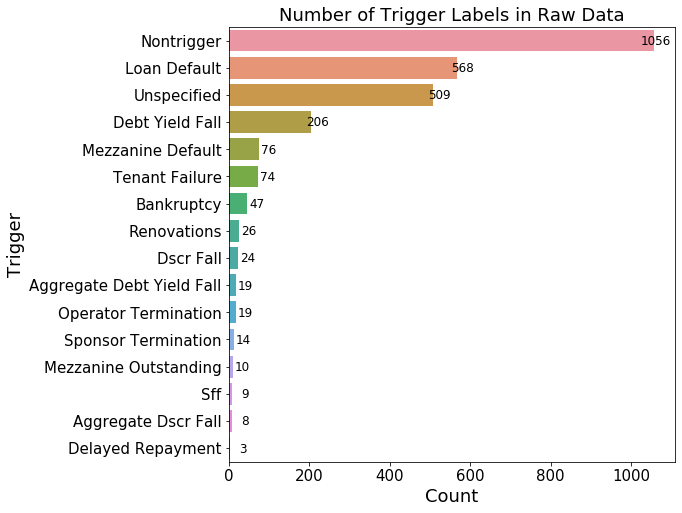

In [9]:
# Call all functions
raw_df = get_data()
raw_df = clean_data(raw_df)
explore_data_cleaning(raw_df)

# Reshape our original dataframe and tokenize to prepare sentences for models
reshaped = reshape_trigger_representation(raw_df)
df = lemmatize_sentences(reshaped)

In [10]:
# Display first few lines of reshaped and lemmatized data set
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,On each Business Day the financial institution...,on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Available funds in each Cash Management Accoun...,available fund in each cash management account...
